In [1]:
import os
import sys
import copy

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import librosa
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import scipy.ndimage
%matplotlib inline

sys.path.append('..')
import libfmp.b
import libfmp.c1
import libfmp.c3

## Análise de Desempenho

Músicos conferem a uma peça de música um toque pessoal, variando continuamente o andamento, a dinâmica e a articulação. Em vez de tocar mecanicamente, aceleram em alguns lugares e desaceleram em outros para dar forma a uma peça musical. Da mesma forma, eles alteram continuamente a intensidade sonora e enfatizam certas notas. Esses aspectos de performance são de importância fundamental para a compreensão e percepção da música. A análise automatizada de diferentes interpretações, também conhecida como análise de performance, é um campo ativo de pesquisa.  
Em termos gerais, pode-se distinguir entre dois objetivos complementares. O primeiro objetivo é encontrar semelhanças entre diferentes interpretações, que permitam derivar regras gerais de performance. Por exemplo, uma regra poderia ser que a maioria dos músicos tende a desacelerar gradualmente no final de uma peça musical, encerrando assim a composição. Um segundo objetivo, ainda mais desafiador, é capturar o que exatamente é característico para o estilo de um intérprete específico. Por exemplo, o que torna Karajan tão especial? E como suas performances diferem das gravações de outros maestros?  
Antes de analisar uma performance específica, é necessário ter informações sobre quando e como as notas da peça de música subjacente são efetivamente tocadas. Portanto, como primeiro passo da análise de performance, é preciso anotar a performance por meio de atributos adequados que tornem o tempo e a intensidade exatos dos diversos eventos de notas explícitos. A extração desses atributos de performance a partir de gravações de áudio constitui um problema desafiador. Muitos pesquisadores anotam manualmente o material de áudio marcando pontos de dados salientes no fluxo de áudio. No entanto, sendo um processo muito trabalhoso, tal procedimento manual é proibitivo diante de grandes coleções de áudio.

## Computação da Curva de Tempo: Ideia Básica

Aqui apresentamos uma abordagem para derivar informações relacionadas ao tempo usando técnicas de sincronização musical. Muitas peças do repertório da música clássica ocidental são baseadas em uma partitura musical. A ideia básica é usar esta partitura como uma versão de referência (onde as posições dos batimentos são assumidas como conhecidas) em comparação com a qual a versão executada pode ser avaliada. O procedimento geral funciona da seguinte forma:  
* Primeiro, a versão de referência é convertida em uma apresentação de rolo de piano, onde as notas são tocadas com um tempo constante conhecido de maneira puramente mecânica.  
* Em seguida, técnicas de sincronização musical são usadas para alinhar temporalmente os eventos de notas e batimentos da referência com suas correspondentes ocorrências físicas em uma versão de áudio executada.  
* O caminho de deformação resultante revela as **diferenças relativas de tempo** entre a performance real e a versão de referência neutra. Conhecendo o tempo absoluto da versão de referência, pode-se derivar o tempo da versão executada em uma determinada posição a partir da inclinação do caminho de deformação.  
Mais precisamente, para derivar um valor de tempo, é necessário "observar" a versão executada ao longo de um certo período de tempo. Para isso, fixamos uma janela de tempo adequada (por exemplo, um intervalo de batida). A partir do caminho de deformação(**warping path**), pode-se ler a duração física correspondente (dada em segundos) da versão executada. A partir disso, pode-se derivar um valor médio de tempo especificado em batidas por minuto (BPM) para a janela de tempo.

Na célula de código seguinte, ilustramos o procedimento esquematicamente usando um exemplo simples. Fixamos uma janela no eixo de tempo de referência com uma duração de uma batida. No exemplo, a primeira batida da versão de referência é alinhada a uma seção da versão executada que dura dois segundos. Em outras palavras, a versão executada tem nesta seção um tempo médio de uma batida a cada dois segundos, resultando em $30$ BPM. Da mesma forma, a segunda batida dura um segundo, correspondendo a $60$ BPM, a terceira batida dura $0.4$ segundos, correspondendo a $150$ BPM, e as quarta e quinta batidas duram $0.3$ segundos, correspondendo a $200$ BPM. Isso resulta em uma **curva de tempo** para a versão executada especificada para cada intervalo de batida da versão de referência.

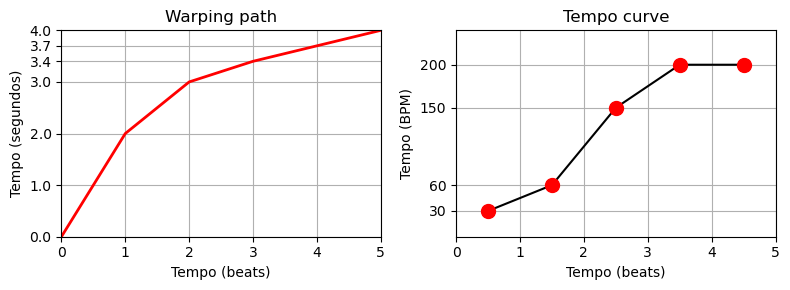

In [2]:
# Definindo o optimal warping path P
P = np.array([[0, 0], [2, 1], [3, 2], [3.4, 3], [3.7, 4], [4, 5]])

# Inicializando uma lista para armazenar os valores de BPM
bpm = []

# Iterando sobre os pontos no caminho de deformação para calcular a curva de tempo em BPM
pos_audio1, pos_score1 = P[0, :]
for pos_audio2, pos_score2  in P[1:]:
    # Calculando a duração em áudio e no escore musical entre dois pontos consecutivos
    dur_audio = pos_audio2 - pos_audio1
    dur_score = pos_score2 - pos_score1
    
    # Calculando o BPM entre os dois pontos e armazenando na lista
    bpm.append(60 * (dur_score / dur_audio))
    
    # Atualizando as posições para o próximo par de pontos
    pos_audio1, pos_score1 = pos_audio2, pos_score2

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(P[:, 1], P[:, 0], 'r-', linewidth=2)
ax[0].set_yticks([0, 1, 2, 3.0, 3.4, 3.7, 4.0])
ax[0].grid()
ax[0].set_xlim([0, 5])
ax[0].set_ylim([0, 4])
ax[0].set_xlabel('Tempo (beats)')
ax[0].set_ylabel('Tempo (segundos)')
ax[0].set_title('Warping path')

ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'k-')
ax[1].plot(np.arange(len(bpm)) + 0.5, bpm, 'ro', markersize=10)
ax[1].set_yticks([30, 60, 150, 200])
ax[1].grid()
ax[1].set_xlim([0, 5])
ax[1].set_ylim([0, 240])
ax[1].set_xlabel('Tempo (beats)')
ax[1].set_ylabel('Tempo (BPM)')
ax[1].set_title('Tempo curve')

plt.tight_layout()


## Calculo do Cromagrama

Seguindo a abordagem descrita, descreveremos agora uma implementação básica para calcular a curva de tempo. Supomos que a versão de referência baseada na partitura seja fornecida na forma de um arquivo CSV contendo os tempos iniciais (dado em Beats), alturas (dada como números de notas MIDI) e durações (dada em beats) dos eventos individuais de notas. Na célula de código a seguir, convertemos a versão de referência (mostrada como representação de piano roll) em um cromagrama da seguinte forma:

* Primeiro, especificamos uma taxa de amostragem (```Fs_beat```) que define o número de quadros por batida(**beat**).
* Em seguida, o **piano roll** é convertido em uma representação de croma somando as faixas de altura que correspondem ao mesmo croma.
* Os recursos de croma resultantes são normalizados em relação à norma $ℓ^2$.

A seguir, usamos ```Fs_beat = 10 ```, o que resulta em $10$ vetores de características por batida. Tendo $35$ batidas em nosso exemplo, isso resulta em uma sequência de características de comprimento $340$. Observe que, ao pensar em uma performance, esse comprimento corresponde a um tempo constante de $130$ BPM usando uma taxa de características de 10 quadros por segundo.  
Da mesma forma, convertemos a gravação de áudio de uma determinada performance em um cromagrama, onde os vetores de croma são novamente normalizados em relação à norma $ℓ^2$. No exemplo subsequente, usamos uma taxa de características de $10Hz$.

Primeiros seis eventos de notas do arquivo CSV da partitura:
   Start  Duration  Pitch  Velocity  instrument
0    0.0      1.50     62       1.0         NaN
1    1.5      0.50     67       1.0         NaN
2    2.0      1.50     70       1.0         NaN
3    3.5      0.50     67       1.0         NaN
4    4.0      1.50     66       1.0         NaN
5    5.5      0.25     67       1.0         NaN


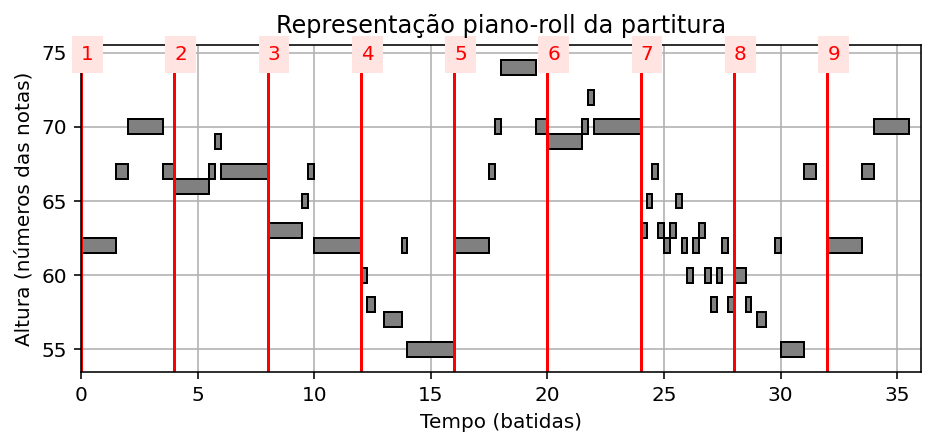

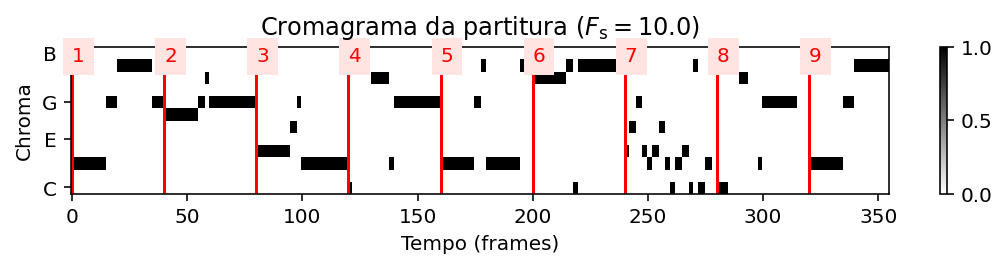

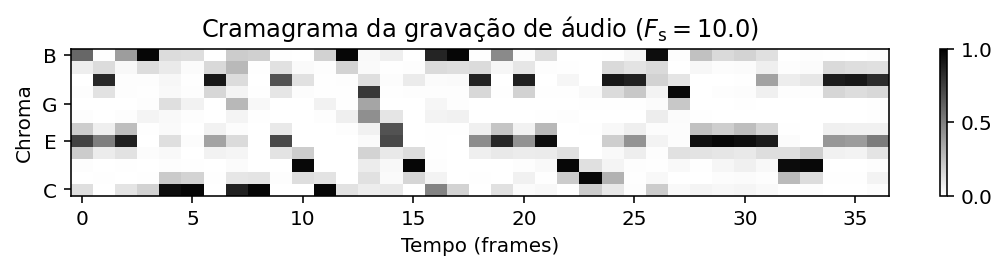

In [3]:
def compute_score_chromagram(score, Fs_beat):
    """Calcula o cromagrama a partir da representação da partitura

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        score (list): Representação da partitura
        Fs_beat (scalar): Taxa de amostragem para o eixo de batida

    Returns:
        X_score (np.ndarray): Representação do cromagrama X_score
        t_beat (np.ndarray): Eixo do tempo t_beat (dado em batidas)
    """
    score_beat_min = min(n[0] for n in score)  # Encontra o tempo de batida mínimo na partitura
    score_beat_max = max(n[0] + n[1] for n in score)  # Encontra o tempo de batida máximo na partitura
    beat_res = 1.0 / Fs_beat  # Resolução do tempo de batida
    t_beat = np.arange(score_beat_min, score_beat_max, beat_res)  # Cria um array de tempo de batida
    X_score = np.zeros((12, len(t_beat)))  # Inicializa o cromagrama com zeros

    for start, duration, pitch, velocity, label in score:
        start_idx = int(round(start / beat_res))  # Converte o tempo inicial em índice
        end_idx = int(round((start + duration) / beat_res))  # Converte o tempo final em índice
        cur_chroma = int(round(pitch)) % 12  # Calcula o valor do croma
        X_score[cur_chroma, start_idx:end_idx] += velocity  # Adiciona a velocidade ao cromagrama

    X_score = librosa.util.normalize(X_score, norm=2)  # Normaliza o cromagrama
    return X_score, t_beat

def plot_measure(ax, measure_pos):
    """Desenha as posições dos compassos

    Notebook: C3/C3S3_MusicAppTempoCurve.ipynb

    Args:
        ax (mpl.axes.Axes): Eixo da figura
        measure_pos (list or np.ndarray): Array contendo posições dos compassos
    """
    y_min, y_max = ax.get_ylim()  # Obtém os limites do eixo y
    ax.vlines(measure_pos, y_min, y_max, color='r')  # Desenha linhas verticais vermelhas nas posições dos compassos
    for m in range(len(measure_pos)):
        ax.text(measure_pos[m], y_max, '%s' % (m + 1),  # Adiciona texto com o número do compasso
                color='r', backgroundcolor='mistyrose',
                verticalalignment='top', horizontalalignment='left')

# Leitura do arquivo de partitura e plotagem da representação piano-roll
fn_score = os.path.join('CSV.csv')
measure_pos_beat = np.array([0, 4, 8, 12, 16, 20, 24, 28, 32])
df = pd.read_csv(fn_score, sep=';')
print('Primeiros seis eventos de notas do arquivo CSV da partitura:')
print(df.loc[0:5, :]) 

score = libfmp.c1.csv_to_list(fn_score)
score = score[:51] #limita o CSV aos primeiros 51 beats
fig, ax = libfmp.c1.visualize_piano_roll(score, xlabel='Tempo (batidas)',
                                         ylabel='Altura (números das notas)', 
                                         colors=['gray'], 
                                         velocity_alpha=False, figsize=(6.6, 3))
ax.set_title('Representação piano-roll da partitura')
ax.get_legend().remove() 
plot_measure(ax, measure_pos_beat)

Fs_beat = 10 
X_score, t_beat = compute_score_chromagram(score, Fs_beat)  # Calcula o cromagrama
figsize = (8, 2)
fig, ax, im = libfmp.b.plot_chromagram(X_score, Fs=1, figsize=figsize, 
                                       xlabel='Tempo (frames)',
                                       title='Cromagrama da partitura ($F_\mathrm{s} = %.1f$)'%Fs_beat,
                                       chroma_yticks=[0, 4, 7, 11])
plot_measure(ax[0], measure_pos_beat * Fs_beat)

# Lê o sinal de áudio
Fs = 22050  # Taxa de amostragem
fn_wav = os.path.join('MIDI.wav')
x, Fs = librosa.load(fn_wav, sr=Fs)  # Carrega o arquivo de áudio

# Calcula e plota o cromagrama do sinal de áudio
N = 4410  # Tamanho da janela da transformada de Fourier 
H = 2205  # Tamanho do salto entre janelas
Fs_X = Fs / 2205  # Nova taxa de amostragem (ajustada)
hop_length = int((350 / (130 / 12)) * H)

X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=hop_length, n_fft=N)
libfmp.b.plot_chromagram(X, figsize=figsize, xlabel='Tempo (frames)', clim=[0, 1],
                         title='Cramagrama da gravação de áudio ($F_\mathrm{s} = %.1f$)'%Fs_X,
                         chroma_yticks=[0, 4, 7, 11]);

## Caminho de Alinhamento
Com base nos cromagramas, aplicamos a DTW para sincronizar a versão de áudio com a versão de referência baseada na partitura.

(30.0, 60.0)

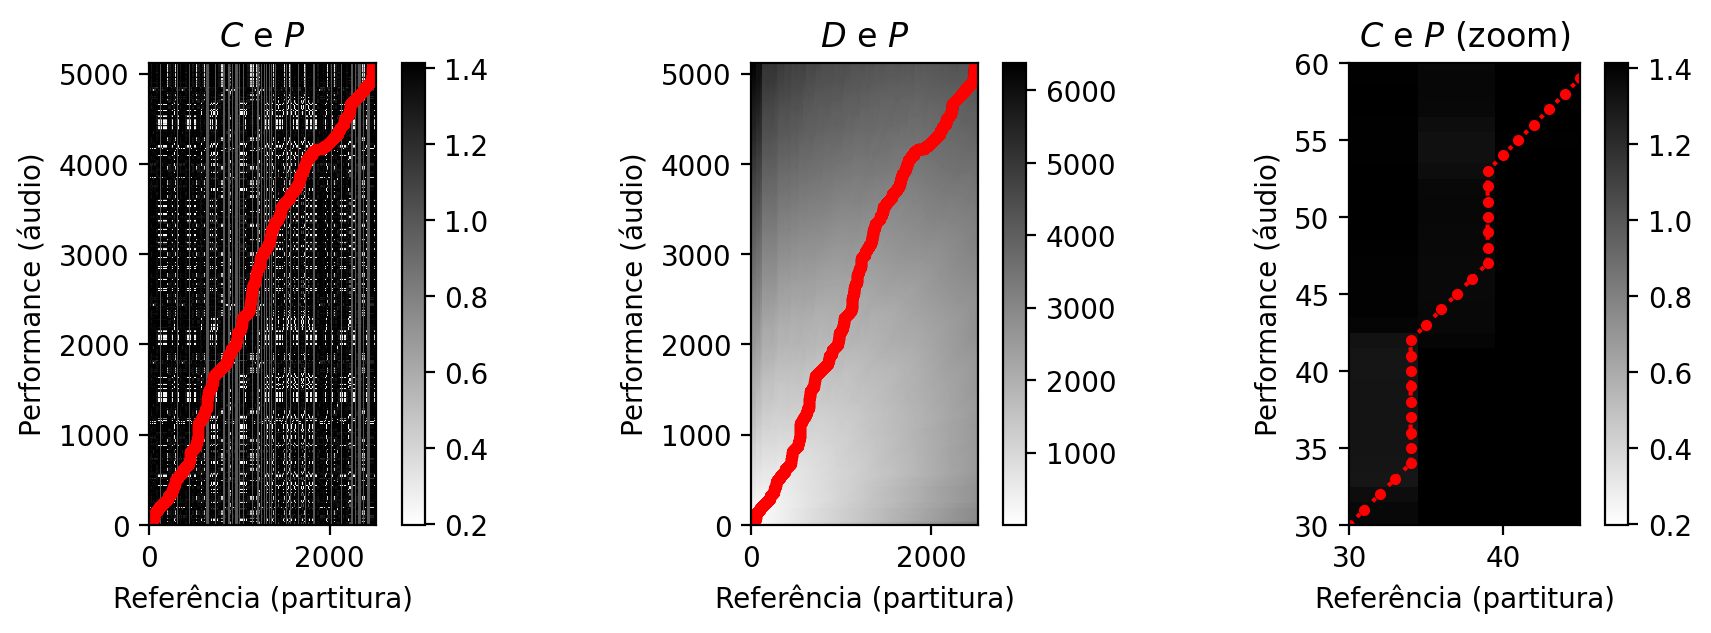

In [4]:
#lendo o CSV e o audio com tamanhos completos
score = libfmp.c1.csv_to_list(fn_score)
Fs_beat = 10 
X_score, t_beat = compute_score_chromagram(score, Fs_beat)
X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, n_fft=N)

# Calcula a DTW e desenha os gráficos de C, D e P
C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean') 
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
P = P[::-1, :]

fig, ax = plt.subplots(1, 3, figsize=(11, 3))  
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance (áudio)', xlabel='Referência (partitura)',
                                  title='$C$ e $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(D, P, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance (áudio)', xlabel='Referência (partitura)',
                                  title='$D$ e $P$', aspect='equal')
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[2]],  
                                  ylabel='Performance (áudio)', xlabel='Referência (partitura)',
                                  title='$C$ e $P$ (zoom)', aspect='equal')
zoom_beat = np.array([3, 4.5])
zoom_sec = np.array([3,6])
ax[2].set_xlim(zoom_beat * Fs_beat)
ax[2].set_ylim(zoom_sec * Fs_beat)

Para calcular diferenças de tempo relativas, basicamente precisa-se derivar a inclinação do Warping Path e então tomar o recíproco para derivar o tempo. Isso, no entanto, se torna problemático quando o Warping path é executado horizontalmente (a inclinação é zero) ou verticalmente (a inclinação é infinita). Removemos tais degenerações excluindo todas as seções horizontais e verticais. Como resultado, obtemos um caminho modificado que é estritamente monótono em ambas as dimensões. Chamamos esse caminho de caminho de alinhamento estrito(strict alignment path). Observe que este caminho não satisfaz mais as condições de tamanho de passo.

Abaixo temos duas implementações alternativas (resultando no mesmo resultado) para converter um Warping Path em um caminho de alinhamento estrito. Nesta construção, garantimos que a condição de fronteira ainda seja válida (ou seja, o caminho resultante começa e termina com as mesmas células (1, 1) e (N, M) que o caminho de deformação original).

Exemplo pequeno:


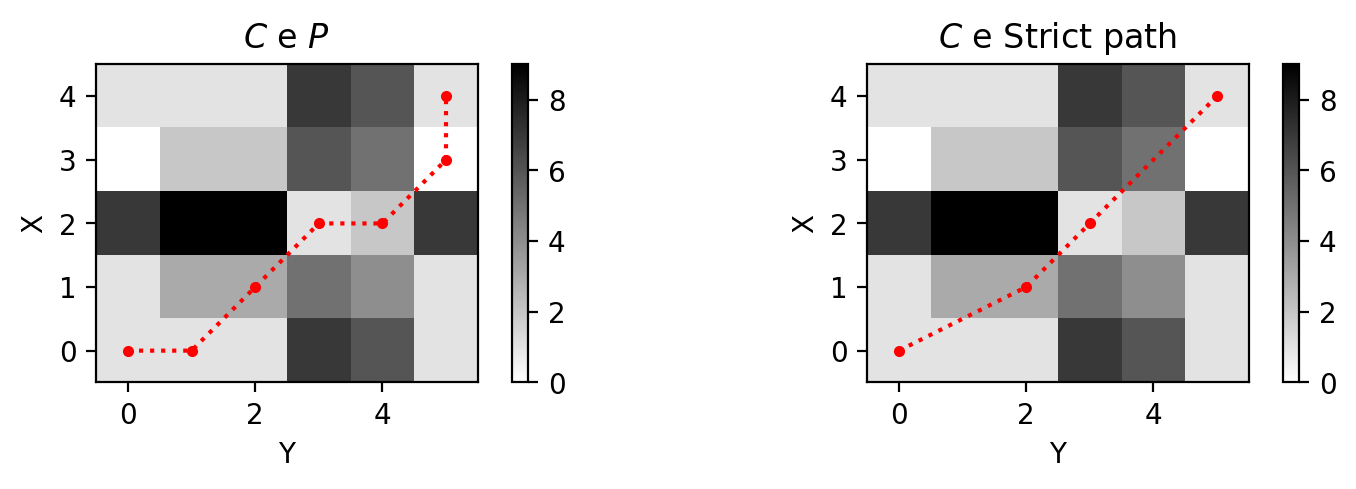

Exemplo de Schumann (zoom):


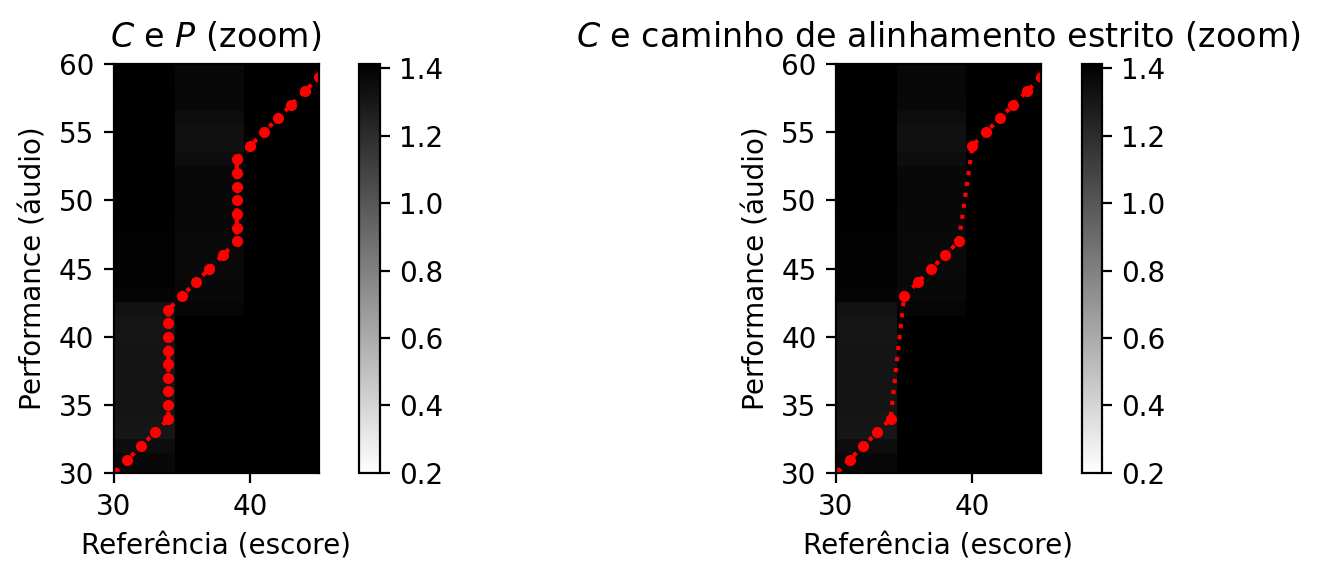

In [5]:
def compute_strict_alignment_path(P):
    """ Calcula o caminho de alinhamento estrito a partir de um Warping path
    Args:
        P (list ou np.ndarray): Warping path
    Returns:
        P_mod (list ou np.ndarray): Caminho de alinhamento estrito """
    # Inicializa P_mod e impõe a condição de limite de início
    P_mod = np.zeros(P.shape)
    P_mod[0] = P[0]
    N, M = P[-1]
    # Percorre todas as células de P até alcançar a última linha ou coluna
    assert N > 1 and M > 1, 'O comprimento das sequências deve ser maior que um.'
    i, j = 0, 0
    n1, m1 = P[i]
    while True:
        i += 1
        n2, m2 = P[i]
        if n2 == N or m2 == M:
            # Se a última linha ou coluna for alcançada, sai do loop
            break
        if n2 > n1 and m2 > m1:
            # A condição de monotonicidade estrita é atendida
            j += 1
            P_mod[j] = n2, m2
            n1, m1 = n2, m2
    j += 1
    # Impõe a condição de limite final
    P_mod[j] = P[-1]
    P_mod = P_mod[:j+1]
    return P_mod

def compute_strict_alignment_path_mask(P):
    """Calcula o caminho de alinhamento estrito a partir de um Warping path
    Args:
        P (list ou np.ndarray): Warping path
    Returns:
        P_mod (list ou np.ndarray): Caminho de alinhamento estrito
    """
    P = np.array(P, copy=True)
    N, M = P[-1]
    # Obtém índices para monotonicidade estrita
    keep_mask = (P[1:, 0] > P[:-1, 0]) & (P[1:, 1] > P[:-1, 1])
    # Adiciona o primeiro índice para impor a condição de limite de início
    keep_mask = np.concatenate(([True], keep_mask))
    # Remove todos os índices da última linha ou coluna
    keep_mask[(P[:, 0] == N) | (P[:, 1] == M)] = False
    # Adiciona o último índice para impor a condição de limite final
    keep_mask[-1] = True
    P_mod = P[keep_mask, :]
    return P_mod

# Exemplo pequeno para testar
print('Exemplo pequeno:')
X_toy =  [1, 3, 9, 2, 1]
Y_toy = [2, 0, 0, 8, 7, 2]
C_toy = libfmp.c3.compute_cost_matrix(X_toy, Y_toy, metric='euclidean')
sigma = np.array([[1, 0], [0, 1], [1, 1]])
D_toy, P_toy = librosa.sequence.dtw(C=C_toy, step_sizes_sigma=sigma)
P_toy = P_toy[::-1, :]  # inverte P
P_toy_mod =  compute_strict_alignment_path(P_toy)

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))    
libfmp.c3.plot_matrix_with_points(C_toy, P_toy, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='X', xlabel='Y',
                                  title='$C$ e $P$', aspect='equal')

libfmp.c3.plot_matrix_with_points(C_toy, P_toy_mod, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='X', xlabel='Y',
                                  title='$C$ e Strict path', aspect='equal')
plt.tight_layout()
plt.show()

print('Exemplo de Schumann (zoom):')
P_mod =  compute_strict_alignment_path(P)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))    
libfmp.c3.plot_matrix_with_points(C, P, linestyle=':', marker='.', ax=[ax[0]],  
                                  ylabel='Performance (áudio)', xlabel='Referência (escore)',
                                  title='$C$ e $P$ (zoom)', aspect='equal')
ax[0].set_xlim(zoom_beat * Fs_beat)
ax[0].set_ylim(zoom_sec * Fs_beat)

libfmp.c3.plot_matrix_with_points(C, P_mod, linestyle=':', marker='.', ax=[ax[1]],  
                                  ylabel='Performance (áudio)', xlabel='Referência (escore)',
                                  title='$C$ e caminho de alinhamento estrito (zoom)', aspect='equal')
ax[1].set_xlim(zoom_beat * Fs_beat)
ax[1].set_ylim(zoom_sec * Fs_beat)
plt.tight_layout()
plt.show()


## Curva de Tempo

O caminho de alinhamento estrito pode ser considerado como uma função estritamente crescente do eixo de referência (dados em beats) para o eixo de tempo da performance (dados em segundos). Intuitivamente falando, a derivada desta função pode ser considerada como uma função de beat-duração, que especifica para cada posição de batida a duração da performance dada em segundos por beat (SPB). Esta função pode ser processada ainda mais aplicando operações de suavização. Por exemplo, pode-se aplicar um filtro de média móvel de um certo comprimento (especificado em beats) para indicar a média móvel da duração ao longo da janela dada. Para realizar essa ideia, usamos nas implementações seguintes as seguintes técnicas:

1. Interpretamos o caminho de alinhamento estrito como uma função de beat para tempo (função f_path_sec).
2. Para preencher as lacunas, usamos técnicas de interpolação linear (linha de tempo de referência t_beat).
3. Em seguida, calculamos uma diferença por quadro para obter uma representação de beat-duração.
4. Aplicamos uma janela de Hann normalizada para suavizar essa representação (comprimento win_len_beat).

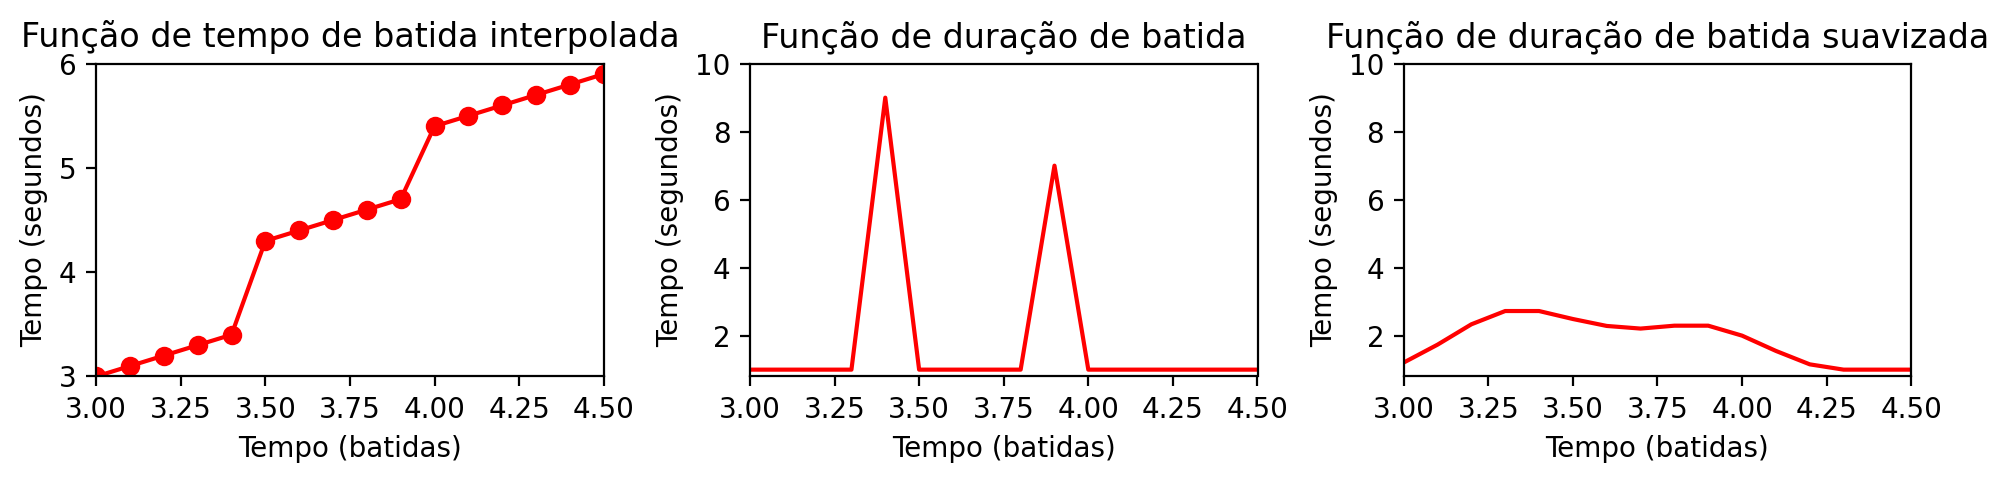

In [6]:
# Converter caminho em função de tempo de batida e interpolar 
t_path_beat = P_mod[:, 1] / Fs_beat
f_path_sec = P_mod[:, 0] / Fs_beat
f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

# Calcular diferença e suavizar com uma janela Hann
f_diff_sec = np.diff(f_sec) * Fs_beat
f_diff_sec = np.concatenate((f_diff_sec, np.array([0])))
win_len_beat = 1
filt_len = int(win_len_beat * Fs_beat)
filt_win = signal.windows.hann(filt_len)
filt_win = filt_win / np.sum(filt_win)
f_diff_smooth_sec = scipy.ndimage.convolve(f_diff_sec, filt_win, mode='nearest')

fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
ax[0].plot(t_beat, f_sec, 'r')
ax[0].plot(t_path_beat, f_path_sec, color='r', marker='o', linestyle='')
ax[0].set_title('Função de tempo de batida interpolada') # Título
ax[0].set_xlim(zoom_beat)
ax[0].set_ylim(zoom_sec)
ax[0].set_xlabel('Tempo (batidas)') # Rótulo do eixo X
ax[0].set_ylabel('Tempo (segundos)') # Rótulo do eixo Y

ax[1].plot(t_beat, f_diff_sec, 'r')
ax[1].set_title('Função de duração de batida') # Título
ax[1].set_xlim(zoom_beat)
ax[1].set_ylim([0.8, 10])
ax[1].set_xlabel('Tempo (batidas)') # Rótulo do eixo X
ax[1].set_ylabel('Tempo (segundos)') # Rótulo do eixo Y

ax[2].plot(t_beat, f_diff_smooth_sec, 'r')
ax[2].set_title('Função de duração de batida suavizada') # Título
ax[2].set_xlim(zoom_beat)
ax[2].set_ylim([0.8, 10])
ax[2].set_xlabel('Tempo (batidas)') # Rótulo do eixo X
ax[2].set_ylabel('Tempo (segundos)') # Rótulo do eixo Y
plt.tight_layout()


A partir da função de beat-duração, é fácil obter uma função de batida-tempo. Para isso, é necessário calcular o inverso dos valores de duração multiplicados por 60 (para obter as batidas por minuto). Esta função resulta no que chamamos simplesmente de curva de tempo. Vale notar que a plotagem de uma curva de tempo usando um eixo de BPM linearmente espaçado leva a uma ênfase exagerada de valores de tempo mais altos em comparação com valores de tempo mais baixos.

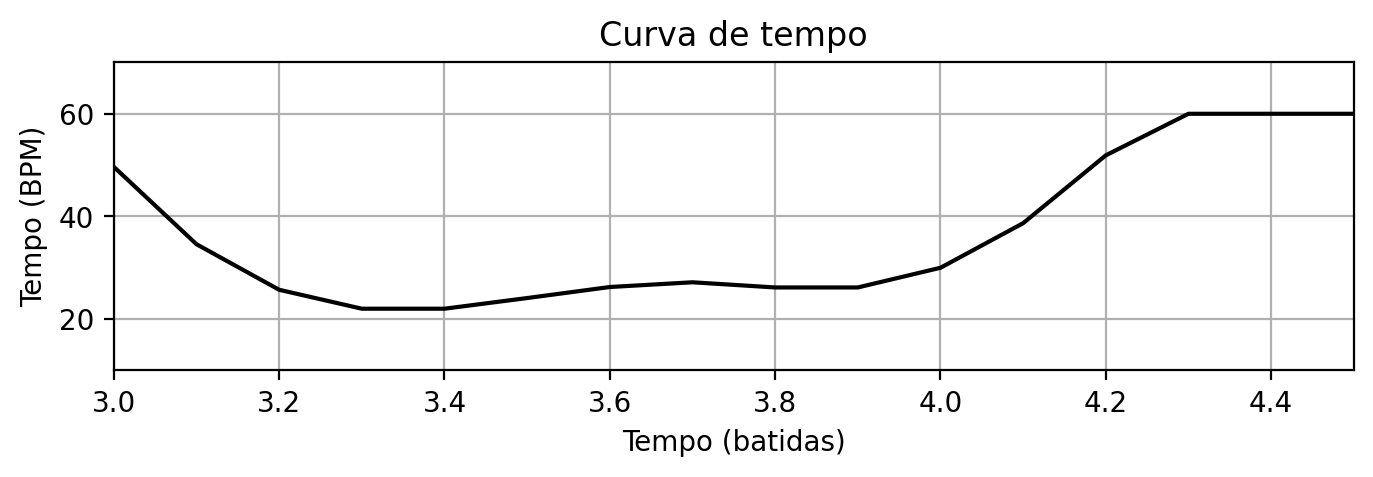

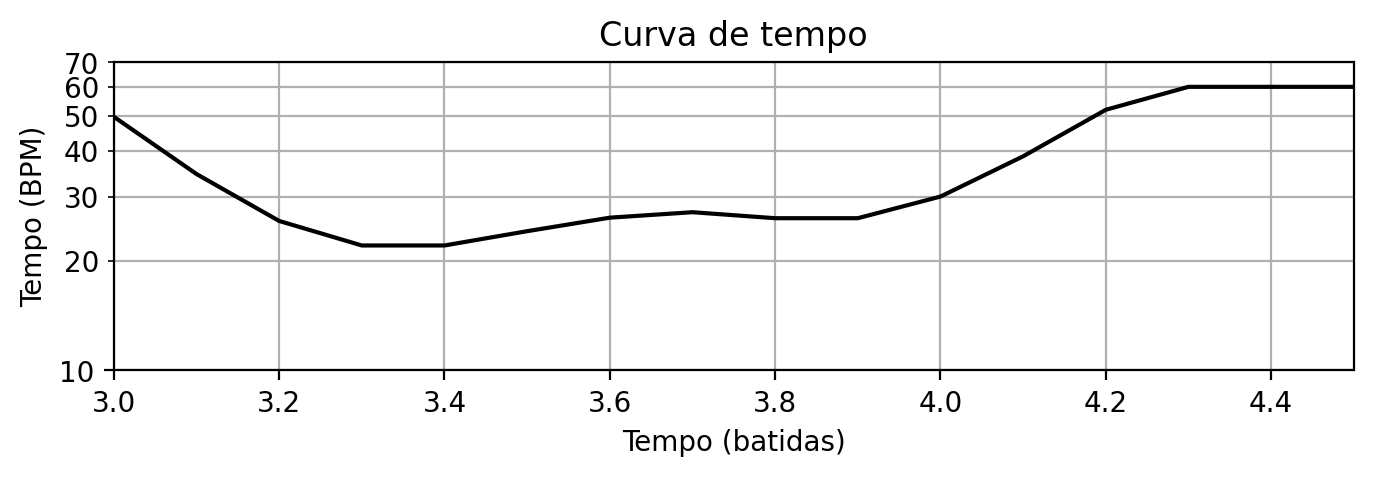

In [7]:
def plot_tempo_curve(f_tempo, t_beat, ax=None, figsize=(8, 2), color='k', logscale=False,
                     xlabel='Tempo (batidas)', ylabel='Tempo (BPM)', xlim=None, ylim=None,
                     label='', measure_pos=[]):
    """Plota uma curva de tempo
    Args:
        f_tempo: Curva de tempo 
        t_beat: Eixo de tempo da curva de tempo (dado como eixo de batidas amostradas)
        ax: Plota como uma figura separada (ax==None) ou dentro de um eixo existente (ax==True) (Valor padrão = None)
        figsize: Tamanho da figura (Valor padrão = (8, 2))
        color: Cor da curva de tempo (Valor padrão = 'k')
        logscale: Usa escala linear (logscale==False) ou logarítmica (logscale==True) para o eixo do tempo (Valor padrão = False)
        xlabel: Rótulo para o eixo x (Valor padrão = 'Tempo (batidas)')
        ylabel: Rótulo para o eixo y (Valor padrão = 'Tempo (BPM)')
        xlim: Limites para o eixo x (Valor padrão = None)
        ylim: Limites para o eixo x (Valor padrão = None)
        label: Rótulo da figura quando plotando dentro de um eixo existente (ax==True) (Valor padrão = '')
        measure_pos: Plota as posições das barras de compasso conforme especificado (Valor padrão = [])

    Returns:
        fig: identificador (handle) da figura
        ax: identificador (handle) dos eixos
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = plt.subplot(1, 1, 1)
    ax.plot(t_beat, f_tempo, color=color, label=label)
    ax.set_title('Curva de tempo')  # Título do gráfico
    if xlim is None:
        xlim = [t_beat[0], t_beat[-1]]  # Calcula limites automáticos para o eixo X se não forem informados 
    if ylim is None:
        ylim = [np.min(f_tempo) * 0.9, np.max(f_tempo) * 1.1]  # Calcula limites automáticos para o eixo Y se não forem informados 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, which='both')  # Exibe linhas de grid

    if logscale:
        ax.set_yscale('log')  # Configura a escala do eixo Y para logarítmica
        ax.yaxis.set_major_formatter(ScalarFormatter())  # Formatador para escala logarítmica
        ax.yaxis.set_minor_formatter(ScalarFormatter())
        # ax.set_yticks([], minor=True)
        # yticks = np.arange(ylim[0], ylim[1]+1, 10)
        # ax.set_yticks(yticks)
    plot_measure(ax, measure_pos)  # Desenha as marcações de barras de compasso (assunto de outra função, suponho)
    return fig, ax

# Uso da função (depois das variáveis serem definidas)
f_tempo = 1. / f_diff_smooth_sec * 60
plot_tempo_curve(f_tempo, t_beat, xlim=zoom_beat, ylim=[10, 70])
plot_tempo_curve(f_tempo, t_beat, xlim=zoom_beat, ylim=[10, 70], logscale=True); 


## Procedimento Geral
Agora definimos a função ```compute_tempo_curve```, que resume o procedimento geral descrito anteriormente.

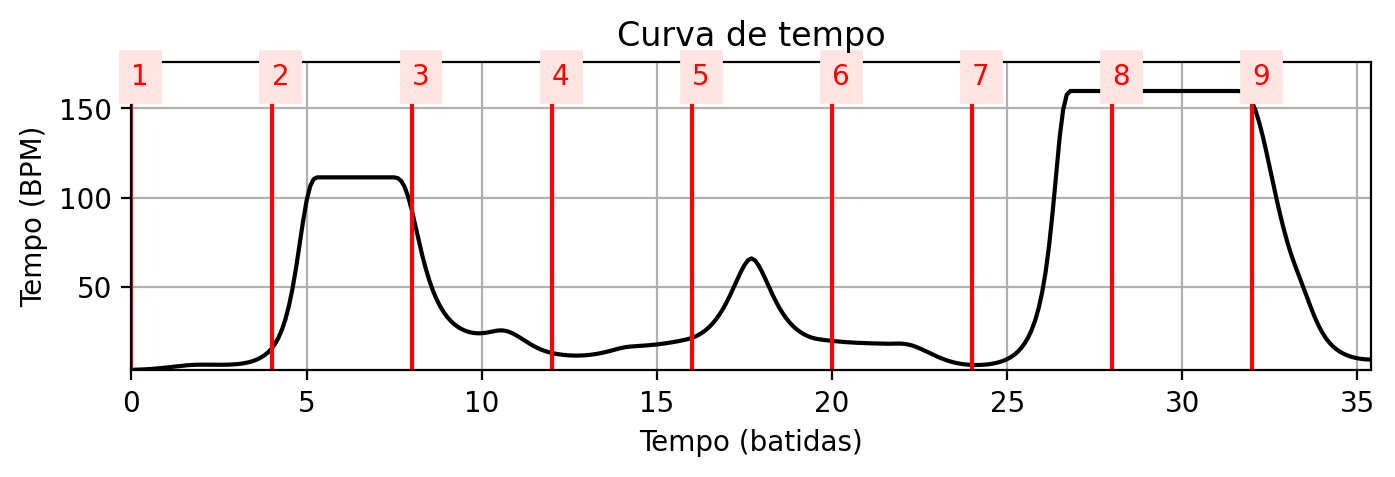

In [8]:
def compute_tempo_curve(score, x, Fs=22050, Fs_beat=10, N=4410, H=2205, shift=0,
                        sigma=np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]),
                        win_len_beat=4):
    """ Calcula a curva de tempo
    Args:
        score (list): Representação da partitura
        x (np.ndarray): Sinal de áudio
        Fs (scalar): Taxa de amostragem do sinal de áudio (Valor padrão = 22050)
        Fs_beat (scalar): Taxa de amostragem para o eixo de batida (Valor padrão = 10)
        N (int): Tamanho da janela para o cálculo do cromagrama do áudio (Valor padrão = 4410)
        H (int): Tamanho do salto para o cálculo do cromagrama de áudio (Valor padrão = 2205)
        shift (int): Deslocamento cíclico aplicado ao cromagrama de áudio (Valor padrão = 0)
        sigma (np.ndarray): Conjunto de tamanhos de passo usado para o DTW
            (Valor padrão = np.array([[1, 0], [0, 1], [2, 1], [1, 2], [1, 1]]))
        win_len_beat (float): Tamanho da janela (dado em batidas) usado para suavização da curva de tempo (Valor padrão = 4)
    Returns:
        f_tempo (np.ndarray): Curva de tempo 
        t_beat (np.ndarray): Eixo do tempo (dado em batidas)"""

    # Calcula o cromagrama da partitura e do áudio 
    X_score, t_beat = compute_score_chromagram(score, Fs_beat)
    Fs_X = Fs / H
    X = librosa.feature.chroma_stft(y=x, sr=Fs, norm=2, tuning=0, hop_length=H, n_fft=N)
    X = np.roll(X, shift, axis=0)  # Desloca o array circularmente

    # Aplica o DTW para computar C, D, P
    C = libfmp.c3.compute_cost_matrix(X, X_score, metric='euclidean')
    D, P = librosa.sequence.dtw(C=C, step_sizes_sigma=sigma)
    P = P[::-1, :]
    P_mod = compute_strict_alignment_path(P)

    # Converte o caminho em uma função tempo-batida e interpola
    t_path_beat = P_mod[:, 1] / Fs_beat
    f_path_sec = P_mod[:, 0] / Fs_X
    f_sec = interp1d(t_path_beat, f_path_sec, kind='linear', fill_value='extrapolate')(t_beat)

    # Calcula a diferença e suaviza com a janela Hann
    f_diff_sec = np.diff(f_sec) * Fs_beat
    pad = np.array([f_diff_sec[-1]])  # Preenchimento para suavização
    f_diff_sec = np.concatenate((f_diff_sec, pad))  
    filt_len = int(win_len_beat * Fs_beat) 
    filt_win = signal.windows.hann(filt_len)
    filt_win = filt_win / np.sum(filt_win)  # Normalização da janela
    f_diff_smooth_sec = scipy.ndimage.convolve(f_diff_sec, filt_win, mode='reflect')

    # Calcula a curva de tempo
    f_tempo = 1. / f_diff_smooth_sec * 60

    return f_tempo, t_beat 

# Carregamento de dados
fn_score = os.path.join('CSV.csv')
score = libfmp.c1.csv_to_list(fn_score)
score = score[:51]

# Carrega o áudio
Fs = 22050
fn_wav = os.path.join('MIDI.wav')
x, Fs = librosa.load(fn_wav,sr = Fs) 

# Cálculo e plotagem da curva de tempo
f_tempo, t_beat = compute_tempo_curve(score, x,H = hop_length)
plot_tempo_curve(f_tempo, t_beat, logscale=False, measure_pos=measure_pos_beat);